Original implementation of Contrastive-sc method
(https://github.com/ciortanmadalina/contrastive-sc)

In [ ]:
# !pip install scipy==1.6.0

In [1]:
import sys
sys.path.append("..")
import argparse
from sklearn.metrics import (adjusted_rand_score, normalized_mutual_info_score,
                             silhouette_score, calinski_harabasz_score,
                             davies_bouldin_score)
from sklearn.cluster import KMeans
from sklearn import metrics

import torch
import torch.nn as nn
import copy
from tqdm.notebook import tqdm
import models
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import st_loss

import h5py
import scipy as sp
import scanpy.api as sc
from collections import Counter
import random
import utils

import pickle
import seaborn as sns
import train
import os
import glob2
plt.ion()
plt.show()
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

/opt/conda/lib/python3.7/site-packages/scanpy/api/__init__.py:7: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning,


In [2]:
path = "../"

category = "real_data"
all_data = pd.read_pickle(
    f"../output/pickle_results/{category}/{category}_combined.pkl")

clrs = [
    '#C0392B', "#F1948A", "#D7BDE2", "#8E44AD", "#7FB3D5", "#2874A6",
    "#76D7C4", "#117A65", '#00ff00', "#F1C40F", "#EB984E", "#839192", "#566573"
]

ordered_methods = [
    'constrastive+KM',
    'scziDesk',
    'scDeepCluster',
    'scrna',
    'cidr',
    'soup',
    'pca_kmeans',
    'constrastive+LD',
    'desc',
    'scanpy-seurat',
    'scedar',
    'scvi',
    'raceid',
]
dataset_names = {
    '10X_PBMC': '10X PBMC',
    '10X_PBMC_select_2100': '10X PBMC (2100)',
    'mouse_ES_cell': 'Mouse ES\nCell',
    'mouse_ES_cell_select_2100': 'Mouse ES\nCell (2100)',
    'worm_neuron_cell_select_2100': 'Worm Neuron\nCell (2100)',
    'worm_neuron_cell': 'Worm\nNeuron\nCell',
    'mouse_bladder_cell': 'Mouse\nBladder\nCell',
    'mouse_bladder_cell_select_2100': 'Mouse Bladder\n Cell (2100)',
    'Quake_Smart-seq2_Trachea': 'QS\nTrachea',
    'Quake_Smart-seq2_Diaphragm': 'QS\nDiaphragm',
    'Quake_10x_Spleen': 'Q Spleen',
    'Quake_10x_Bladder': 'Q Bladder',
    'Quake_Smart-seq2_Lung': 'QS Lung',
    'Quake_10x_Limb_Muscle': 'Q Limb\nMuscle',
    'Quake_Smart-seq2_Limb_Muscle': 'QS Limb\nMuscle',
}

all_data["dataset_label"] = all_data["dataset"].apply(
    lambda x: dataset_names.get(x, x))

datasets = [
    'Quake_Smart-seq2_Trachea',
    'Quake_10x_Bladder',
    'Quake_10x_Spleen',
    'Quake_Smart-seq2_Diaphragm',
    'Quake_10x_Limb_Muscle',
    'Quake_Smart-seq2_Limb_Muscle',
    'Romanov',
    'Adam',
    'Muraro',
    'Young',
    'Quake_Smart-seq2_Lung',
    '10X_PBMC',
    'mouse_ES_cell',
    'worm_neuron_cell',
    'mouse_bladder_cell',
]

ordered_datasets = dict(zip(datasets, np.arange(len(datasets))))
ordered_methods_map = dict(zip(ordered_methods, np.arange(len(ordered_methods))))


all_data["ordered_dataset"] = all_data["dataset"].apply(lambda x: ordered_datasets[x])

all_data[all_data["method"]=='constrastive+KM'].groupby("dataset").mean()

# ARI per dataset plot

In [4]:
rank = all_data.groupby(["dataset", "method"])["ARI"].mean().unstack("method").round(3).T
rank = rank.rank(ascending=False, method = "min")
rankKM = rank.T["constrastive+KM"]
rankLD = rank.T["constrastive+LD"]
# rank = pd.concat([rankKM, rankLD], axis = 1)
# rank["rank"] = rank.apply(lambda x: min(x.values), axis = 1)
# rank = rank["rank"] 

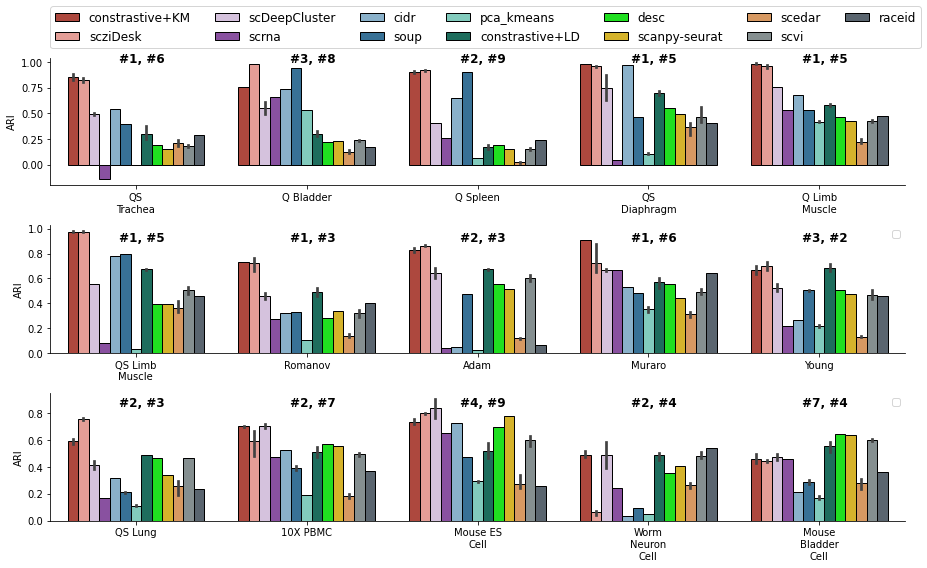

In [21]:
plt.figure(figsize=(14, 8))
first_datasets = datasets[:5]
ax = plt.subplot(311)

sns.barplot(x="dataset_label",
            y="ARI",
            hue="method",
            data=all_data[all_data["dataset"].isin(first_datasets)].sort_values(
                by=["order", "ordered_dataset"]),
            palette=clrs,
            edgecolor='black',
            linewidth=1,
            ax=ax)
# Ranking
seld = all_data[all_data["dataset"].isin(first_datasets)].sort_values(
    by=["order", "ordered_dataset"])["dataset"].unique()
for i, d in enumerate(seld):
    plt.text(i-0.1, 1, f"#{int(rankKM[d])}, #{int(rankLD[d])}", fontsize = 12, fontweight="bold")
# plt.grid()
plt.legend(bbox_to_anchor=(0, 1.4), loc=2, borderaxespad=0., ncol=7, fontsize = 12)
plt.xlabel("")
sns.despine()
ax.spines['bottom'].set_visible(False)

first_datasets = datasets[5:10]
ax = plt.subplot(312)

sns.barplot(x="dataset_label",
            y="ARI",
            hue="method",
            data=all_data[all_data["dataset"].isin(first_datasets)].sort_values(
                by=["order", "ordered_dataset"]),
            palette=clrs,
            edgecolor='black',
            linewidth=1,
            ax=ax)
# Ranking
seld = all_data[all_data["dataset"].isin(first_datasets)].sort_values(
    by=["order", "ordered_dataset"])["dataset"].unique()
for i, d in enumerate(seld):
    plt.text(i-0.1, 0.9, f"#{int(rankKM[d])}, #{int(rankLD[d])}", fontsize = 12, fontweight="bold")
# plt.grid()
plt.legend([])
plt.xlabel("")
sns.despine()
ax.spines['bottom'].set_visible(False)


first_datasets = datasets[10:]
ax = plt.subplot(313)

sns.barplot(x="dataset_label",
            y="ARI",
            hue="method",
            data=all_data[all_data["dataset"].isin(first_datasets)].sort_values(
                by=["order", "ordered_dataset"]),
            palette=clrs,
            edgecolor='black',
            linewidth=1,
            ax=ax)
# Ranking
seld = all_data[all_data["dataset"].isin(first_datasets)].sort_values(
    by=["order", "ordered_dataset"])["dataset"].unique()
for i, d in enumerate(seld):
    plt.text(i-0.1, 0.85, f"#{int(rankKM[d])}, #{int(rankLD[d])}", fontsize = 12, fontweight="bold")
# plt.grid()
plt.legend([])
plt.xlabel("")
sns.despine()
# ax.spines['bottom'].set_visible(False)
plt.tight_layout()
plt.savefig(f"../diagrams/{category}_ARI_barplot.pdf", bbox_inches='tight')

# NMI, Silhouette, Calinski per dataset

In [ ]:
method_color = dict(zip(ordered_methods, clrs))

sel_methods = ['constrastive+KM', 'scziDesk',  'scDeepCluster','desc','scanpy-seurat']
sel_clrs = [method_color[m] for m in sel_methods]

In [ ]:
plt.figure(figsize = (14, 7))
ax = plt.subplot(311)
plt.title("(a) NMI", fontweight = "bold")
sns.barplot(x = "dataset_label", y="NMI", hue = "method", 
            data = all_data[all_data["method"].isin(sel_methods)].sort_values(by=["order", "ordered_dataset"]),
            palette=sel_clrs,
           edgecolor='black',
    linewidth=1,
           ax = ax)
plt.legend(bbox_to_anchor=(0, 1.4), loc=2, borderaxespad=0., ncol = 7)
plt.xlabel("")
sns.despine()

ax = plt.subplot(312)
plt.title("(b) Silhouette", fontweight = "bold")
sns.barplot(x = "dataset_label", y="Silhouette", hue = "method", 
            data = all_data[all_data["method"].isin(sel_methods)].sort_values(by=["order", "ordered_dataset"]),
            palette=sel_clrs,
           edgecolor='black',
    linewidth=1,
           ax = ax)
plt.legend([])
plt.xlabel("")
sns.despine()


ax = plt.subplot(313)
plt.title("(c) Calinski", fontweight = "bold")
sns.barplot(x = "dataset_label", y="Calinski", hue = "method", 
            data = all_data[all_data["method"].isin(sel_methods)].sort_values(by=["order", "ordered_dataset"]),
            palette=sel_clrs,
           edgecolor='black',
    linewidth=1,
           ax = ax)
plt.legend([])
plt.xlabel("")
sns.despine()
plt.tight_layout()
plt.savefig(f"../diagrams/{category}_NMI_internal_barplot.pdf", bbox_inches='tight')

# Computational time analysis

In [36]:
all_data = pd.read_pickle(f"../output/pickle_results/{category}/{category}_combined.pkl")
df = pd.read_pickle(f"../output/pickle_results/{category}/{category}_baseline_cpu.pkl")
df_k_cpu = df[[
    'dataset',
    'dropout',
    'kmeans_ari',
    'kmeans_nmi',
    'run',
    "t_k"

]].rename(columns={
    'kmeans_ari': "ARI",
    'kmeans_nmi': "NMI",
    "t_k": "time"
})
df_k_cpu["method"] = "constrastive+KM CPU"

df_l_cpu = df[[
    'dataset',
    'dropout',
    'leiden_ari',
    'leiden_nmi',
    'run',
    "t_l"

]].rename(columns={
    'leiden_ari': "ARI",
    'leiden_nmi': "NMI",
    "t_l": "time"
})
df_l_cpu["method"] = "constrastive+LD CPU"

all_data_comp = pd.concat([all_data, df_k_cpu, df_l_cpu])
bold_names = {
    'constrastive+KM': "$\\bf{constrastive+KM}$",
    'constrastive+KM CPU': "$\\bf{constrastive+KM}$ $\\bf{(CPU)}$",
    'constrastive+LD': "$\\bf{constrastive+LD}$",
    'constrastive+LD CPU': "$\\bf{constrastive+LD}$ $\\bf{(CPU)}$"
}
all_data_comp["method"] = all_data_comp["method"].apply(lambda x: bold_names.get(x, x))
# ordered_methods = [
#     "constrastive+KM",
#     "constrastive+KM CPU",
#     'constrastive+LD',
#     'constrastive+LD CPU',
#     'scziDesk',
#     'scDeepCluster',
#     'scrna',
#     'cidr',
#     'soup',
#     'pca_kmeans',
#     'desc',
#     'scanpy-seurat',
#     'scedar',
#     'scvi',
#     'raceid',
# ]

all_data_comp = all_data_comp.groupby("method")[["time"]].mean()


ref_time = all_data_comp.groupby("method")["time"].mean()[bold_names.get("constrastive+KM")]

all_data_comp["Factor"] = all_data_comp["time"].apply(lambda x: x/ref_time)
all_data_comp= all_data_comp.sort_values(by = "time")

all_data_comp = all_data_comp.rename(columns={"time": "Avg time(sec)"})

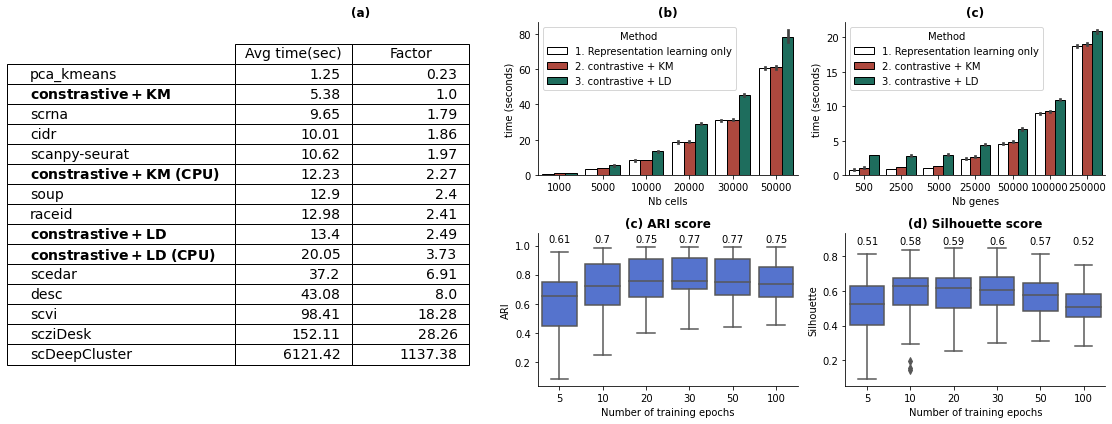

In [41]:
colours = ['white', '#C0392B', "#117A65",]
plt.figure(figsize = (16, 6))
ax = plt.subplot(1, 3, 1)
ax.axis("off")
table = ax.table(cellText=all_data_comp.round(2).values,
          rowLabels=all_data_comp.index,
          colLabels=all_data_comp.columns,
          loc='center left'
        )
plt.title("(a)", fontweight = "bold")
table.scale(0.9, 1.5)
table.set_fontsize(16)

###
ax = plt.subplot(2, 3, 2)
plt.title("(b)", fontweight = "bold")
sc = pd.read_pickle(f"../output/pickle_results/balanced_data/balanced_data_scalability_cells.pkl")

sc = sc[["nb_cells", "t_k", "t_l", "t_training"]]
sc["nb_cells"] =sc["nb_cells"].astype(int)
sc = sc.rename(columns = {"nb_cells": "Nb cells", 
                          "t_k": "2. contrastive + KM", 
                          "t_l": "3. contrastive + LD", 
                          "t_training": "1. Representation learning only"})

sc = pd.melt(sc, id_vars="Nb cells",).rename(columns={"variable" : "Method"}).sort_values(by = "Method")

sns.barplot(x = "Nb cells", y= "value",hue = "Method", data = sc,
           palette=colours,
           edgecolor='black',)
plt.ylabel("time (seconds)")
sns.despine()

####
ax = plt.subplot(2, 3, 3)
plt.title("(c)", fontweight = "bold")
sc = pd.read_pickle(f"../output/pickle_results/balanced_data/balanced_data_scalability_genes.pkl")

sc = sc[["nb_genes", "t_k", "t_l", "t_training"]]
sc["nb_genes"] =sc["nb_genes"].astype(int)
sc = sc.rename(columns = {"nb_genes": "Nb genes", 
                          "t_k": "2. contrastive + KM", 
                          "t_l": "3. contrastive + LD", 
                          "t_training": "1. Representation learning only"})

sc = pd.melt(sc, id_vars="Nb genes",).rename(columns={"variable" : "Method"}).sort_values(by = "Method")

sns.barplot(x = "Nb genes", y= "value",hue = "Method", data = sc,
           palette=colours,
           edgecolor='black',)
plt.ylabel("time (seconds)")
sns.despine()

#### Number of epochs
nb_epochs = pd.read_pickle(f"../output/pickle_results/real_data/real_data_nb_epochs.pkl")
nb_epochs["nb_epochs"] = nb_epochs["nb_epochs"].astype("int")

ax = plt.subplot(2, 3, 5)
sns.boxplot(data = nb_epochs, x = "nb_epochs", y='kmeans_ari', ax = ax, color="royalblue")
plt.ylabel("ARI")
plt.xlabel("Number of training epochs")
sns.despine()
plt.title("(c) ARI score", fontweight = "bold")
means = nb_epochs.groupby(['nb_epochs'])['kmeans_ari'].mean().values
mean_labels = [str(np.round(s, 2)) for s in means]
pos = range(len(means))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick], 1.02, mean_labels[tick], 
            horizontalalignment='center', #size='x-small', color='w', weight='semibold'
           )
ymin, ymax = ax.get_ylim()
plt.ylim((ymin, ymax + 0.05))
    
    
ax = plt.subplot(2, 3, 6)
sns.boxplot(data = nb_epochs, x = "nb_epochs", y='kmeans_sil', ax = ax, color="royalblue")
plt.ylabel("Silhouette")
plt.xlabel("Number of training epochs")
sns.despine()
means = nb_epochs.groupby(['nb_epochs'])['kmeans_sil'].mean().values
mean_labels = [str(np.round(s, 2)) for s in means]
pos = range(len(means))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick], 0.87, mean_labels[tick], 
            horizontalalignment='center', #size='x-small', color='w', weight='semibold'
           )
plt.title("(d) Silhouette score", fontweight = "bold")
ymin, ymax = ax.get_ylim()
plt.ylim((ymin, ymax + 0.05))
plt.tight_layout()

plt.savefig(f"../diagrams/computational_analysis.pdf", bbox_inches='tight')

# Data augmentation analysis

In [95]:
layers = pd.read_pickle(f"../output/pickle_results/real_data/real_data_layers_new.pkl")
dropout = layers[layers["layers"] == "[200, 40, 60]"]

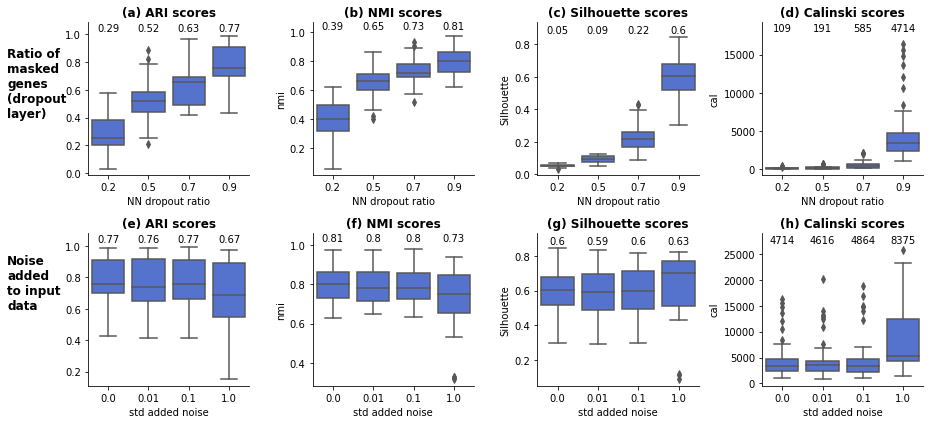

In [102]:
plt.figure(figsize = (13,6))
ax = plt.subplot(241)
sns.boxplot(data = dropout, x = "dropout", y='kmeans_ari', ax = ax, color="royalblue")
means = dropout.groupby(['dropout'])['kmeans_ari'].mean().values
mean_labels = [str(np.round(s, 2)) for s in means]
pos = range(len(means))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick], 1.02, mean_labels[tick], 
            horizontalalignment='center', #size='x-small', color='w', weight='semibold'
           )
plt.ylabel("ARI")
plt.xlabel("NN dropout ratio")
sns.despine()
plt.title("(a) ARI scores", fontweight = "bold")
ymin, ymax = ax.get_ylim()
plt.ylim((ymin, ymax + 0.05))
plt.text(-2.5, 0.4, "Ratio of\nmasked\ngenes\n(dropout\nlayer)", 
         fontweight = "bold", fontsize = 12)
plt.ylabel("")


ax = plt.subplot(242)
sns.boxplot(data = dropout, x = "dropout", y='kmeans_nmi', ax = ax, color="royalblue")
means = dropout.groupby(['dropout'])['kmeans_nmi'].mean().values
mean_labels = [str(np.round(s, 2)) for s in means]
pos = range(len(means))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick], 1.02, mean_labels[tick], 
            horizontalalignment='center', #size='x-small', color='w', weight='semibold'
           )
plt.ylabel("nmi")
plt.xlabel("NN dropout ratio")
sns.despine()
plt.title("(b) NMI scores", fontweight = "bold")
ymin, ymax = ax.get_ylim()
plt.ylim((ymin, ymax + 0.05))



ax = plt.subplot(243)
sns.boxplot(data = dropout, x = "dropout", y='kmeans_sil', ax = ax, color="royalblue")
plt.ylabel("Silhouette")
means = dropout.groupby(['dropout'])['kmeans_sil'].mean().values
mean_labels = [str(np.round(s, 2)) for s in means]
pos = range(len(means))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick], 0.87, mean_labels[tick], 
            horizontalalignment='center', #size='x-small', color='w', weight='semibold'
           )
plt.xlabel("NN dropout ratio" )
sns.despine()
plt.title("(c) Silhouette scores", fontweight = "bold")
ymin, ymax = ax.get_ylim()
plt.ylim((ymin, ymax + 0.05))


ax = plt.subplot(244)
sns.boxplot(data = dropout, x = "dropout", y='kmeans_cal', ax = ax, color="royalblue")
means = dropout.groupby(['dropout'])['kmeans_cal'].mean().values
mean_labels = [str(int(s)) for s in means]
pos = range(len(means))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick], 18000, mean_labels[tick], 
            horizontalalignment='center', #size='x-small', color='w', weight='semibold'
           )
plt.ylabel("cal")
plt.xlabel("NN dropout ratio")
sns.despine()
plt.title("(d) Calinski scores", fontweight = "bold")
ymin, ymax = ax.get_ylim()
plt.ylim((ymin, ymax + 2000))
#####
noise = pd.read_pickle(f"../output/pickle_results/real_data/real_data_noise.pkl")
ax = plt.subplot(245)
sns.boxplot(data = noise, x = "noise", y='kmeans_ari', ax = ax, color="royalblue")
means = noise.groupby(['noise'])['kmeans_ari'].mean().values
mean_labels = [str(np.round(s, 2)) for s in means]
pos = range(len(means))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick], 1.02, mean_labels[tick], 
            horizontalalignment='center', #size='x-small', color='w', weight='semibold'
           )
plt.ylabel("ARI")
plt.xlabel("std added noise")
sns.despine()
plt.title("(e) ARI scores", fontweight = "bold")
ymin, ymax = ax.get_ylim()
plt.ylim((ymin, ymax + 0.05))
plt.text(-2.5, 0.6, "Noise\nadded\nto input\ndata", 
         fontweight = "bold", fontsize = 12)
plt.ylabel("")


ax = plt.subplot(246)
sns.boxplot(data = noise, x = "noise", y='kmeans_nmi', ax = ax, color="royalblue")
means = noise.groupby(['noise'])['kmeans_nmi'].mean().values
mean_labels = [str(np.round(s, 2)) for s in means]
pos = range(len(means))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick], 1.02, mean_labels[tick], 
            horizontalalignment='center', #size='x-small', color='w', weight='semibold'
           )
plt.ylabel("nmi")
plt.xlabel("std added noise")
sns.despine()
plt.title("(f) NMI scores", fontweight = "bold")
ymin, ymax = ax.get_ylim()
plt.ylim((ymin, ymax + 0.05))

ax = plt.subplot(247)
sns.boxplot(data = noise, x = "noise", y='kmeans_sil', ax = ax, color="royalblue")
plt.ylabel("Silhouette")
means = noise.groupby(['noise'])['kmeans_sil'].mean().values
mean_labels = [str(np.round(s, 2)) for s in means]
pos = range(len(means))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick], 0.87, mean_labels[tick], 
            horizontalalignment='center', #size='x-small', color='w', weight='semibold'
           )
plt.xlabel("std added noise")
sns.despine()
plt.title("(g) Silhouette scores", fontweight = "bold")
ymin, ymax = ax.get_ylim()
plt.ylim((ymin, ymax + 0.05))


ax = plt.subplot(248)
sns.boxplot(data = noise, x = "noise", y='kmeans_cal', ax = ax, color="royalblue")
means = noise.groupby(['noise'])['kmeans_cal'].mean().values
mean_labels = [str(int(s)) for s in means]
pos = range(len(means))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick], 27000, mean_labels[tick], 
            horizontalalignment='center', #size='x-small', color='w', weight='semibold'
           )
plt.ylabel("cal")
plt.xlabel("std added noise")
sns.despine()
plt.title("(h) Calinski scores", fontweight = "bold")
ymin, ymax = ax.get_ylim()
plt.ylim((ymin, ymax + 2000))

plt.tight_layout()
plt.savefig(f"../diagrams/{category}_data_augmentation.pdf", bbox_inches='tight')

# Nb input genes analysis

In [24]:
nb_genes = pd.read_pickle(f"../output/pickle_results/real_data/real_data_nb_genes.pkl")
nb_genes = nb_genes[nb_genes["nb_genes"]!= "random_half"]
nb_genes["ordered_dataset"] = nb_genes["dataset"].apply(lambda x: ordered_datasets[x])

ordered_genes = ['all','random_half',  500, 1000, 1500, 3000, 5000]

ordered_genes = dict(zip(ordered_genes, np.arange(len(ordered_genes))))

nb_genes["order"] = nb_genes["nb_genes"].apply(lambda x: ordered_genes[x])

def format_label(x, boxplot = False):
    if x == "all":
        if boxplot:
            return "all genes"
        else:
            return "all\ngenes"
    if x == "random_half":
        if boxplot:
            return "random 1/2 genes"
        else:
            return "random 1/2\ngenes"
    else:
        return str(int(x))
nb_genes["nb_genes_boxplot"] = nb_genes["nb_genes"].apply(lambda x:format_label(x, boxplot = True) )
nb_genes["nb_genes"] = nb_genes["nb_genes"].apply(lambda x:format_label(x) )

nb_genes["dataset_label"] = nb_genes["dataset"].apply(
    lambda x: dataset_names.get(x, x))
nb_genes=nb_genes.sort_values(by= "order",  ascending = True)

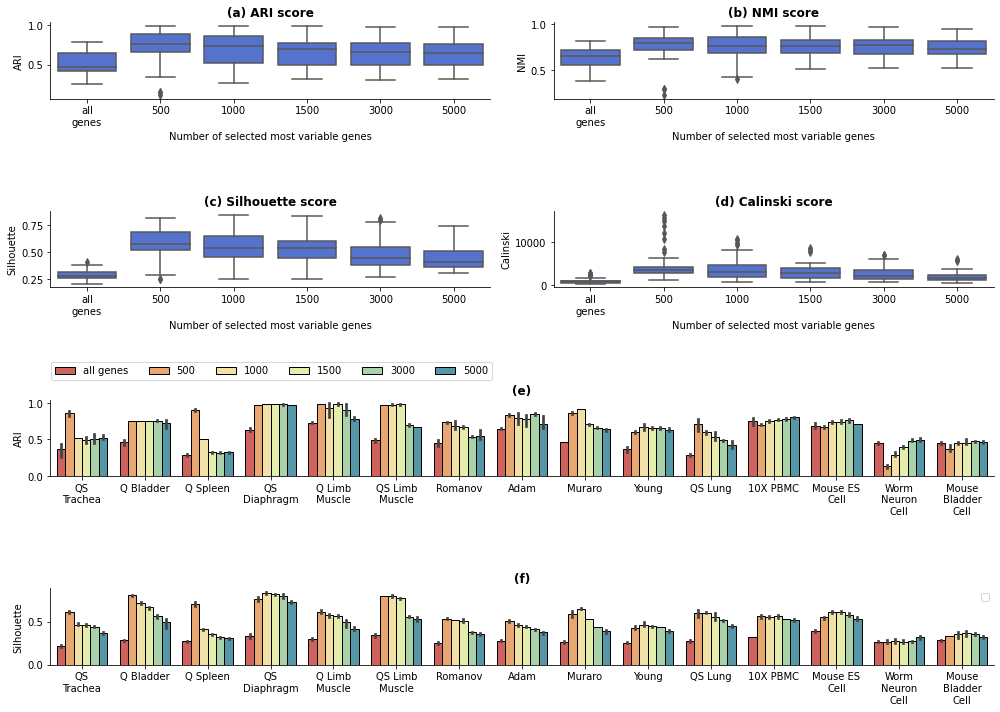

In [26]:
plt.figure(figsize=(14, 10))

ax = plt.subplot(421)
sns.boxplot(data=nb_genes,
            x="nb_genes",
            y='kmeans_ari_0',
            ax=ax,
            color="royalblue")
plt.ylabel("ARI")
plt.xlabel("Number of selected most variable genes")
sns.despine()
plt.title("(a) ARI score", fontweight="bold")
ax = plt.subplot(422)
sns.boxplot(data=nb_genes,
            x="nb_genes",
            y='kmeans_nmi_0',
            ax=ax,
            color="royalblue")
plt.ylabel("NMI")
plt.xlabel("Number of selected most variable genes")
sns.despine()
plt.title("(b) NMI score", fontweight="bold")



ax = plt.subplot(423)
sns.boxplot(data=nb_genes,
            x="nb_genes",
            y='kmeans_sil_0',
            ax=ax,
            color="royalblue")
plt.ylabel("Silhouette")
plt.xlabel("Number of selected most variable genes")
sns.despine()
plt.title("(c) Silhouette score", fontweight="bold")


ax = plt.subplot(424)
sns.boxplot(data=nb_genes,
            x="nb_genes",
            y='kmeans_cal_0',
            ax=ax,
            color="royalblue")
plt.ylabel("Calinski")
plt.xlabel("Number of selected most variable genes")
sns.despine()
plt.title("(d) Calinski score", fontweight="bold")


ax = plt.subplot(413)
sns.barplot(data=nb_genes.sort_values(by=["ordered_dataset", "order"]),
            x="dataset_label",
            y="kmeans_ari_0",
            hue="nb_genes_boxplot",
            palette = "Spectral",
            edgecolor='black',
            ax=ax)
plt.legend(bbox_to_anchor=(0.001, 1.5), loc=2, borderaxespad=0., ncol=7)
plt.ylabel("ARI")
# plt.grid()
plt.title("(e)", fontweight="bold")
plt.xlabel("")
sns.despine()

ax = plt.subplot(414)
sns.barplot(data=nb_genes.sort_values(by=["ordered_dataset", "order"]),
            x="dataset_label",
            y="kmeans_sil_0",
            hue="nb_genes_boxplot",
            palette = "Spectral",
            edgecolor='black',
            ax=ax)
plt.legend([])
# plt.grid()
plt.ylabel("Silhouette")
plt.title("(f)", fontweight="bold")
plt.xlabel("")
sns.despine()

plt.tight_layout()
plt.savefig(f"../diagrams/{category}_nb_genes.pdf", bbox_inches='tight')

In [ ]:
# a = nb_genes[nb_genes["nb_genes"] == '500']["kmeans_ari_0"].values

# b = nb_genes[nb_genes["nb_genes"] == "all\ngenes"]["kmeans_ari_0"].values

# print(sp.stats.ttest_ind(a, b, axis=0, equal_var=True, nan_policy='propagate', alternative='greater'))

In [ ]:
# a = nb_genes[nb_genes["nb_genes"] == '500']["kmeans_nmi_0"].values

# b = nb_genes[nb_genes["nb_genes"] == "all\ngenes"]["kmeans_nmi_0"].values

# print(sp.stats.ttest_ind(a, b, axis=0, equal_var=True, nan_policy='propagate', alternative='greater'))

# Robustness to the number of selected cells

In [83]:
train_size = pd.read_pickle(f"../output/pickle_results/real_data/real_data_train_size.pkl")


In [84]:
methods_no_clust = [
    'constrastive+LD',
    'desc',
    'scanpy-seurat',
    'scedar',
    'scvi',
    'raceid',
]
all_data1 = pd.read_pickle(f"../output/pickle_results/{category}/{category}_combined.pkl")

In [85]:

all_data1 = all_data1.groupby(["method", "dataset"]).std()/all_data1.groupby(["method", "dataset"]).mean()
all_data1 = all_data1.abs()
all_data1= all_data1.reset_index()

# all_data1 =all_data1.groupby(["method"]).std().reset_index()
all_data1["order"] = all_data1["method"].apply(lambda x: ordered_methods_map[x])
all_data1["method"] = all_data1["method"].apply(lambda x: f"{x} (*)" if x in methods_no_clust else x )
all_data1.head()

,method,dataset,dropout,ARI,NMI,Silhouette,Calinski,time,order
0,cidr,10X_PBMC,NaN,0.0,0.0,0.0,0.0,0.003617,4
1,cidr,Adam,NaN,0.0,0.0,0.0,0.0,0.036482,4
2,cidr,Muraro,NaN,0.0,0.0,0.0,0.0,0.010331,4
3,cidr,Quake_10x_Bladder,NaN,0.0,0.0,0.0,0.0,0.023061,4
4,cidr,Quake_10x_Limb_Muscle,NaN,0.0,0.0,0.0,0.0,0.012892,4


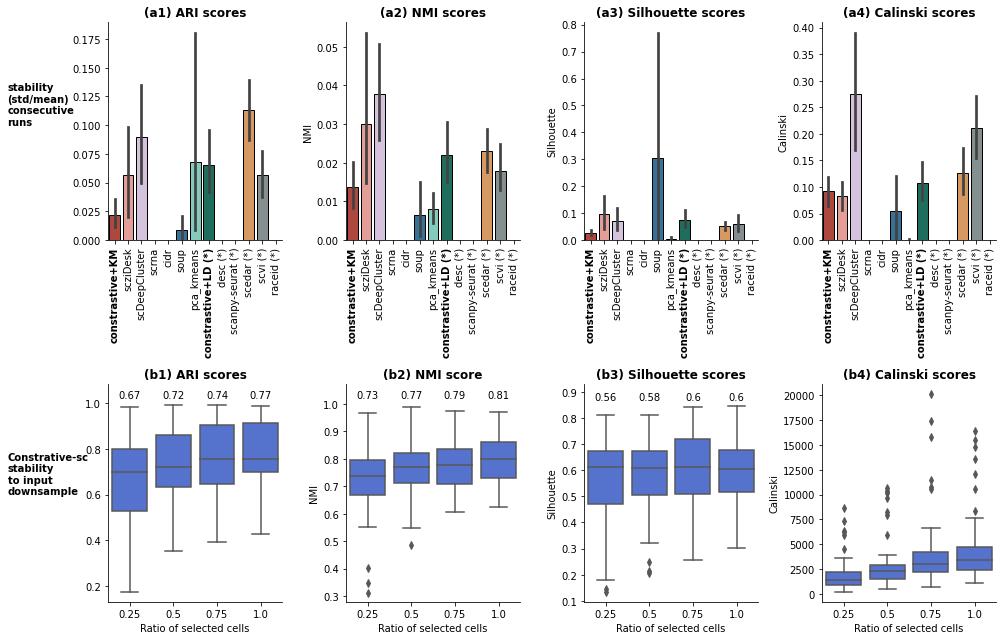

In [94]:
plt.figure(figsize=(14, 9))
letters = ["(a)", "(b)", "(c)", "(d)",
           "(e)", "(f)","(g)" ,"(h)",
           "(i)","(j)","(k)", "(l)"]
titles = ["real data"]
nb_rows=2
i = 0
ax = plt.subplot(nb_rows,4, 1)
sns.barplot(x = "method", y="ARI", data = all_data1.sort_values(by="order"),
           palette=clrs,
           edgecolor='black',
    linewidth=1)
plt.xticks(rotation = 90)
plt.title(f"(a1) ARI scores", fontweight = "bold")
plt.xlabel("")
sns.despine()
plt.gca().get_xticklabels()[0].set_fontweight('bold') 
plt.gca().get_xticklabels()[7].set_fontweight('bold') 
plt.text(-8, 0.1, "stability\n(std/mean)\nconsecutive\nruns", fontweight = "bold")
plt.ylabel("")

ax = plt.subplot(nb_rows,4, 2)
sns.barplot(x = "method", y="NMI", data = all_data1.sort_values(by="order"),
           palette=clrs,
           edgecolor='black',
    linewidth=1)
plt.xticks(rotation = 90)
plt.title(f"(a2) NMI scores", fontweight = "bold")
plt.xlabel("")
sns.despine()
plt.gca().get_xticklabels()[0].set_fontweight('bold') 
plt.gca().get_xticklabels()[7].set_fontweight('bold') 

ax = plt.subplot(nb_rows,4, 3)
sns.barplot(x = "method", y="Silhouette", data = all_data1.sort_values(by="order"),
           palette=clrs,
           edgecolor='black',
    linewidth=1)
plt.xticks(rotation = 90)
plt.title(f"(a3) Silhouette scores", fontweight = "bold")
plt.xlabel("")
sns.despine()
plt.gca().get_xticklabels()[0].set_fontweight('bold') 
plt.gca().get_xticklabels()[7].set_fontweight('bold') 

ax = plt.subplot(nb_rows,4, 4)
sns.barplot(x = "method", y="Calinski", data = all_data1.sort_values(by="order"),
           palette=clrs,
           edgecolor='black',
    linewidth=1)
plt.xticks(rotation = 90)
plt.title(f"(a4) Calinski scores", fontweight = "bold")
plt.xlabel("")
sns.despine()
plt.gca().get_xticklabels()[0].set_fontweight('bold') 
plt.gca().get_xticklabels()[7].set_fontweight('bold') 


## stability input cells
ax = plt.subplot(245)
g = sns.boxplot(data = train_size, x = "train_size", y='kmeans_ari', ax = ax, color="royalblue")
means = train_size.groupby(['train_size'])['kmeans_ari'].mean().values
mean_labels = [str(np.round(s, 2)) for s in means]
pos = range(len(means))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick], 1.02, mean_labels[tick], 
            horizontalalignment='center', #size='x-small', color='w', weight='semibold'
           )
plt.ylabel("ARI")
plt.xlabel("Ratio of selected cells")
sns.despine()
plt.title("(b1) ARI scores", fontweight = "bold")
ymin, ymax = ax.get_ylim()
plt.ylim((ymin, ymax + 0.05))
plt.text(-2.8, 0.6, "Constrative-sc\nstability\nto input\ndownsample", fontweight = "bold")
plt.ylabel("")

ax = plt.subplot(246)
g = sns.boxplot(data = train_size, x = "train_size", y='kmeans_nmi', ax = ax, color="royalblue")
means = train_size.groupby(['train_size'])['kmeans_nmi'].mean().values
mean_labels = [str(np.round(s, 2)) for s in means]
pos = range(len(means))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick], 1.02, mean_labels[tick], 
            horizontalalignment='center', #size='x-small', color='w', weight='semibold'
           )
plt.ylabel("NMI")
plt.xlabel("Ratio of selected cells")
sns.despine()
plt.title("(b2) NMI score",  fontweight = "bold")
ymin, ymax = ax.get_ylim()
plt.ylim((ymin, ymax + 0.05))



ax = plt.subplot(247)
sns.boxplot(data = train_size, x = "train_size", y='kmeans_sil', ax = ax, color="royalblue")
means = train_size.groupby(['train_size'])['kmeans_sil'].mean().values
mean_labels = [str(np.round(s, 2)) for s in means]
pos = range(len(means))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick], 0.87, mean_labels[tick], 
            horizontalalignment='center', #size='x-small', color='w', weight='semibold'
           )
plt.ylabel("Silhouette")
plt.xlabel("Ratio of selected cells")
sns.despine()
plt.title("(b3) Silhouette scores",  fontweight = "bold")
ymin, ymax = ax.get_ylim()
plt.ylim((ymin, ymax + 0.05))

ax = plt.subplot(248)
sns.boxplot(data = train_size, x = "train_size", y='kmeans_cal', ax = ax, color="royalblue")
# means = train_size.groupby(['train_size'])['kmeans_cal'].mean().values
# mean_labels = [str(np.round(s, 2)) for s in means]
# pos = range(len(means))
# for tick,label in zip(pos,ax.get_xticklabels()):
#     ax.text(pos[tick], 20000, mean_labels[tick], 
#             horizontalalignment='center', #size='x-small', color='w', weight='semibold'
#            )
plt.ylabel("Calinski")
plt.xlabel("Ratio of selected cells")
sns.despine()
plt.title("(b4) Calinski scores",  fontweight = "bold")

plt.tight_layout()
plt.savefig(f"../diagrams/{category}_stability.pdf", bbox_inches='tight')

In [ ]:
# a = train_size[train_size["train_size"] == 1]["kmeans_ari"].values

# b = train_size[train_size["train_size"] == 0.5]["kmeans_ari"].values

# print(sp.stats.ttest_ind(a, b, axis=0, equal_var=True, nan_policy='propagate', alternative='greater'))

In [ ]:
# a = train_size[train_size["train_size"] == 1]["kmeans_sil"].values

# b = train_size[train_size["train_size"] == 0.5]["kmeans_sil"].values

# print(sp.stats.ttest_ind(a, b, axis=0, equal_var=True, nan_policy='propagate', alternative='greater'))

# Neural Architecture Search

In [103]:
train_size = pd.read_pickle(f"../output/pickle_results/real_data/real_data_train_size.pkl")

In [104]:
layers = pd.read_pickle(f"../output/pickle_results/real_data/real_data_layers_new.pkl")
layers.head()

layers["nb_layers"] = layers["layers"].apply(lambda x: len(x.split(",")))
layers["embedding_size"] = layers["layers"].apply(lambda x: int(x.split(",")[-1].replace("[", '')[:-1]))

layers9 = layers[layers["dropout"]==0.9]

r = layers.groupby(["layers", "dropout"
                    ])["kmeans_ari"].mean().unstack(["layers"
                                                       ]).T.reset_index()
r["nb_layers"] = r["layers"].apply(lambda x: len(x.split(",")))
r["embedding_size"] = r["layers"].apply(
    lambda x: int(x.split(",")[-1].replace("[", '')[:-1]))
r = r.sort_values(by=["nb_layers", "embedding_size"]).drop(
    ["nb_layers", "embedding_size"], axis=1).reset_index(drop=True).round(3).set_index("layers")

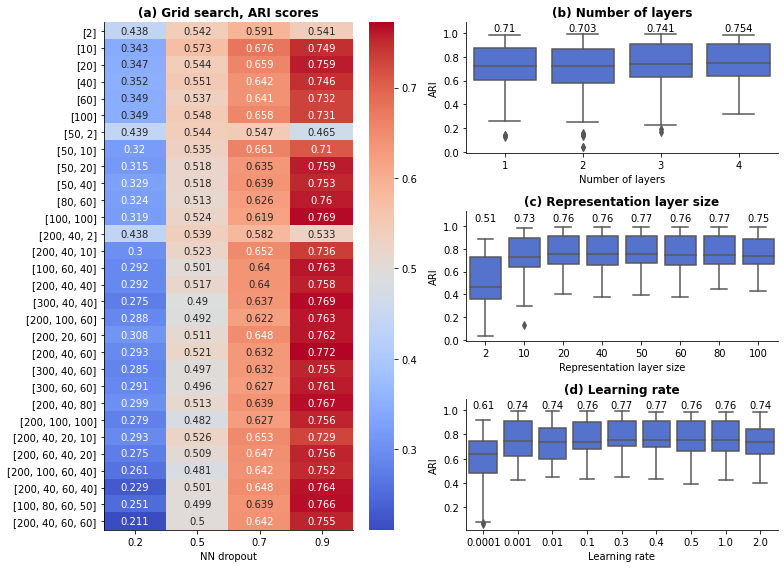

In [109]:
plt.figure(figsize = (11, 8))

ax = plt.subplot(1,2,1)
ax = plt.gca()
sns.heatmap(r, annot = True, cmap = "coolwarm",fmt='.3g', ax = ax)
plt.ylabel("");
plt.xlabel("NN dropout")
plt.title("(a) Grid search, ARI scores", fontweight = "bold")


ax = plt.subplot(3,2,2)
sns.boxplot(data =layers9, x = 'nb_layers', y = 'kmeans_ari'  , ax = ax,color="royalblue" )
means = layers9.groupby(['nb_layers'])['kmeans_ari'].mean().values
mean_labels = [str(np.round(s, 3)) for s in means]
pos = range(len(means))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick], 1.02, mean_labels[tick], 
            horizontalalignment='center', #size='x-small', color='w', weight='semibold'
           )
plt.ylabel("ARI")
plt.xlabel("Number of layers")
sns.despine()
plt.title("(b) Number of layers", fontweight = "bold")
ymin, ymax = ax.get_ylim()
plt.ylim((ymin, ymax + 0.05))


ax = plt.subplot(3,2,4)
sns.boxplot(data =layers9, x = 'embedding_size', y = 'kmeans_ari'  , ax = ax, color="royalblue")
means = layers9.groupby(['embedding_size'])['kmeans_ari'].mean().values
mean_labels = [str(np.round(s, 2)) for s in means]
pos = range(len(means))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick], 1.04, mean_labels[tick], 
            horizontalalignment='center', #size='x-small', color='w', weight='semibold'
           )
plt.ylabel("ARI")
plt.xlabel("Representation layer size")
sns.despine()
plt.title("(c) Representation layer size", fontweight = "bold")
ymin, ymax = ax.get_ylim()
plt.ylim((ymin, ymax + 0.09))





ax = plt.subplot(3,2,6)
lr = pd.read_pickle(f"../output/pickle_results/real_data/real_data_lr.pkl")
sns.boxplot(data = lr, x = "lr", y='kmeans_ari', ax = ax, color="royalblue")
means = lr.groupby(['lr'])['kmeans_ari'].mean().values
mean_labels = [str(np.round(s, 2)) for s in means]
pos = range(len(means))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick], 1.02, mean_labels[tick], 
            horizontalalignment='center', #size='x-small', color='w', weight='semibold'
           )
plt.ylabel("ARI")
plt.xlabel("Learning rate")
sns.despine()
plt.title("(d) Learning rate", fontweight = "bold")
ymin, ymax = ax.get_ylim()
plt.ylim((ymin, ymax + 0.05))

plt.tight_layout()
plt.savefig(f"../diagrams/grid_search.pdf", bbox_inches='tight')

# Clustering analysis

In [42]:
df = pd.read_pickle(f"../output/pickle_results/{category}/{category}_baseline.pkl")
scDeepCluster = pd.read_pickle(f"../output/pickle_results/{category}/{category}_scDeepCluster1.pkl")
scDeepCluster["method"] = "scDeepCluster"

sczi = pd.read_pickle(f"../output/pickle_results/{category}/{category}_sczi.pkl")
sczi["method"] = "scziDesk"

datasets = ['Quake_10x_Limb_Muscle', 'Quake_10x_Bladder', 'Muraro', "Romanov", "Young"
           ]

In [43]:
def get_2d(all_data, dataset):
    ours = all_data[(all_data["dataset"] == dataset) & (all_data["run"] == 0)]
    ari = round(ours["ARI"].values[0], 2)
    emb = ours["features"].values[0]
    n_clust = np.unique(ours["pred"].values[0]).shape[0]

    X_embedded = TSNE(n_components=2).fit_transform(emb)

    X_embedded = pd.DataFrame(data= X_embedded, columns = ["x", "y"])

    X_embedded["clusters"] = ours["pred"].values[0]
    X_embedded["clusters"] = X_embedded["clusters"].apply(lambda x : f"c {x}")
    return X_embedded, ari, n_clust

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


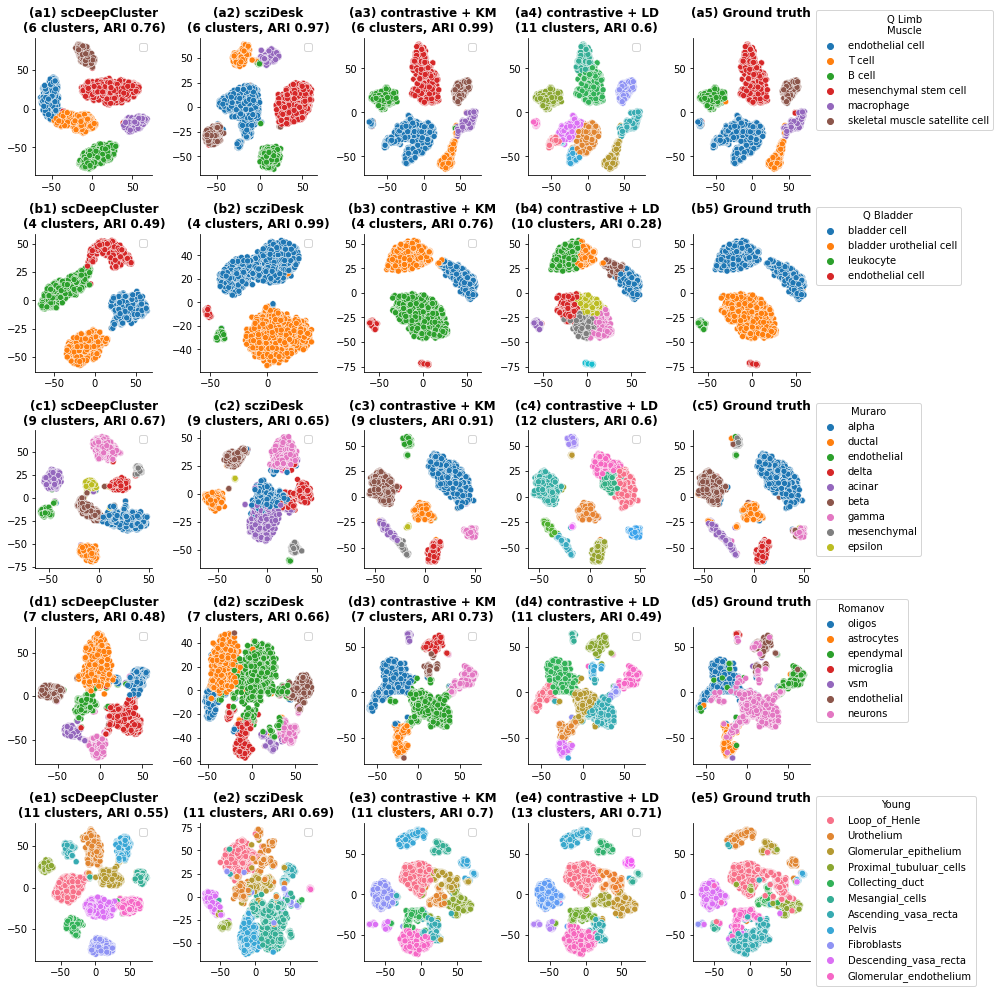

In [45]:
n = len(datasets)
titles = ["a", "b", "c", "d", "e", "f"]
plt.figure(figsize = (14, 2.8*n))
n_cols = 5
for i in range(n):
    dataset = datasets[i]
    # scDeepCluster
    X_embedded, ari, n_clust = get_2d(scDeepCluster, dataset)
    ax = plt.subplot(n, n_cols, i*n_cols+1)
    p = sns.scatterplot(data=X_embedded,
               x='x',
               y='y',
               hue="clusters",
               ax = ax
              )
    plt.xlabel("")
    plt.ylabel("")
    plt.legend([])
    plt.title(f"({titles[i]}1) scDeepCluster\n({n_clust} clusters, ARI {ari})", fontweight = "bold")
    sns.despine()
    
    # sczi
    X_embedded, ari, n_clust = get_2d(sczi, dataset)
    ax = plt.subplot(n, n_cols, i*n_cols+2)
    p = sns.scatterplot(data=X_embedded,
               x='x',
               y='y',
               hue="clusters",
               ax = ax
              )
    plt.xlabel("")
    plt.ylabel("")
    plt.legend([])
    plt.title(f"({titles[i]}2) scziDesk\n({n_clust} clusters, ARI {ari})", fontweight = "bold")
    sns.despine()
    
    
    # OURS
    data_mat = h5py.File(f"{path}real_data/{dataset}.h5", "r")
    X = np.array(data_mat['X'])
    Y = np.array(data_mat['Y'])

    cell_names = data_mat['cell_names'][()]

    ours = df[(all_data["dataset"] == dataset) & (df["run"] == 0)]

    emb = ours["features"].values[0]

    X_embedded = TSNE(n_components=2).fit_transform(emb)

    X_embedded = pd.DataFrame(data= X_embedded, columns = ["x", "y"])
    X_embedded[dataset] = cell_names

    X_embedded["K Means"] = ours["kmeans_pred"].values[0]
    X_embedded["Leiden"] = ours["leiden_pred"].values[0]

    X_embedded["K Means"] = X_embedded["K Means"].apply(lambda x : f"c {x}")
    X_embedded["Leiden"] = X_embedded["Leiden"].apply(lambda x : f"c {x}")
    # plot
    ax = plt.subplot(n, n_cols, i*n_cols+3)
    p = sns.scatterplot(data=X_embedded,
               x='x',
               y='y',
               hue="K Means",
               ax = ax
              )
    plt.xlabel("")
    plt.ylabel("")
    plt.legend([])
    ari = round(ours["kmeans_ari"].values[0], 2)
    n_clust = X_embedded["K Means"].unique().shape[0]
    plt.title(f"({titles[i]}3) contrastive + KM\n({n_clust} clusters, ARI {ari})", fontweight = "bold")
    sns.despine()
    
    
    ax = plt.subplot(n, n_cols, i*n_cols+4)
    sns.scatterplot(data=X_embedded,
               x='x',
               y='y',
               hue="Leiden",
               ax = ax,
              )
    ari = round(ours["leiden_ari"].values[0], 2)
    n_clust = X_embedded["Leiden"].unique().shape[0]
    plt.title(f"({titles[i]}4) contrastive + LD\n({n_clust} clusters, ARI {ari})", fontweight = "bold")
    plt.legend([])
    plt.xlabel("")
    plt.ylabel("")
    sns.despine()

    ax = plt.subplot(n, n_cols, i*n_cols+5)
    sns.scatterplot(data=X_embedded,
               x='x',
               y='y',
               hue=dataset,
               ax = ax
              )
    plt.legend(bbox_to_anchor=(1.05,1.2), loc=2, borderaxespad=0., ncol = 1, 
               title = dataset_names.get(dataset, dataset) )
    plt.title(f"({titles[i]}5) Ground truth\n", fontweight = "bold")
    plt.xlabel("")
    plt.ylabel("")
    sns.despine()
    
plt.tight_layout()

plt.savefig(f"../diagrams/{category}_TSNE_clusters.pdf", bbox_inches='tight')

In [ ]:
dataset = 'Quake_10x_Limb_Muscle'

In [ ]:
data_mat = h5py.File(f"{path}real_data/{dataset}.h5", "r")
X = np.array(data_mat['X'])
Y = np.array(data_mat['Y'])

cell_names = data_mat['cell_names'][()]

ours = df[(all_data["dataset"] == dataset) & (df["run"] == 0)]

pred = ours["kmeans_pred"].values[0]

In [ ]:
Xb = (X>0).astype(int)

In [ ]:
idx4 = np.where(pred == 4)[0]
idx1 = np.where(pred == 1)[0]

In [ ]:
pred[idx1] = 4
pred[idx4] = 1

In [ ]:
pred[idx][:20]

In [ ]:
idx3 = np.where(pred == 3)[0]
idx0 = np.where(pred == 0)[0]

In [ ]:
pred[idx3] = 0
pred[idx0] = 3

In [ ]:
pred[idx][:20]

In [ ]:
Y[idx][:20]

In [ ]:
plt.hist(X.mean( axis = 1), bins = 30, log= True)

plt.hist(X[idx].mean( axis = 1), bins = 30, log= True)

In [ ]:
plt.figure(figsize = (10, 3))
plt.subplot(121)
plt.title("(a) Average cell expression value \nin Q Limb Muscle", fontweight = "bold")
plt.hist(X.mean( axis = 1), bins = 30);

plt.subplot(122)
plt.title("(b) Average expression value in cells \npredicted in the wrong cluster", fontweight = "bold")
plt.hist(X[idx] .mean( axis = 1), bins = 30);
sns.despine()
plt.savefig(f"../diagrams/{category}_wrong_predictions.pdf", bbox_inches='tight')

# ARI correlation

In [ ]:
df = all_data[['dataset', "method", 'ARI', 'NMI','Silhouette', 'Calinski']]
df.head()

df['Silhouette'] = df['Silhouette'].astype(float)
df['Calinski'] = df['Calinski'].astype(float)

corr_ari = None

for method in df.method.unique():
    desc_m = df[df["method"] == method]
    desc_m = desc_m.corr()[["ARI"]].rename(columns={"ARI": method})
    if corr_ari is None:
        corr_ari = desc_m
    else:
        corr_ari = pd.concat([corr_ari, desc_m], axis =1)

corr_ari = corr_ari.round(2)

idx = corr_ari.index.values
idx = [f"corr(ARI-{x})" for x in idx]

corr_ari = corr_ari.reset_index()

corr_ari["index"] = idx
corr_ari

corr_ari = corr_ari[corr_ari["index"]!= "corr(ARI-ARI)"]
corr_ari = corr_ari[corr_ari["index"]!= "corr(ARI-Calinski)"]


corr_sil = None

for method in df.method.unique():
    desc_m = df[df["method"] == method]
    desc_m = desc_m.corr()[["Silhouette"]].rename(columns={"Silhouette": method})
    if corr_sil is None:
        corr_sil = desc_m
    else:
        corr_sil = pd.concat([corr_sil, desc_m], axis =1)

corr_sil = corr_sil.round(2)

idx = corr_sil.index.values
idx = [f"corr(Silhouette-{x})" for x in idx]

corr_sil = corr_sil.reset_index()

corr_sil["index"] = idx
corr_sil

corr_sil = corr_sil[corr_sil["index"]!= "corr(Silhouette-Silhouette)"]
corr_sil = corr_sil[corr_sil["index"]!= "corr(Silhouette-ARI)"]
corr_sil = corr_sil[corr_sil["index"]!= "corr(Silhouette-Calinski)"]


corr_ari = pd.concat([corr_ari, corr_sil])

corr_ari  = corr_ari.set_index("index", drop = True)

In [ ]:
# plt.figure(figsize = (12, 2))
# ax = plt.gca()
# sns.heatmap(corr_ari[ordered_methods], annot = True, cmap = "coolwarm", ax = ax)
# plt.ylabel("");
# plt.savefig(f"../diagrams/ari_corr_arielation.pdf", bbox_inches='tight')

# Correlation score vs sparsity, etc

In [ ]:
desc = pd.read_excel("../output/pickle_results/real_data/description.xlsx")
desc = desc[['dataset', 'nb_clusters', 'sparsity', 'max_value',
       'non_zero_mean', 'non_zero_median', 'non_zero_skew', 'non_zero_kurosis']]
desc.head()


df = all_data[['dataset', "method", "ARI"]]

desc = pd.merge(desc, df, on = "dataset", how = "right")

corr = None

for method in desc.method.unique():
    desc_m = desc[desc["method"] == method]
    desc_m = desc_m.corr()[["ARI"]].rename(columns={"ARI": method})
    if corr is None:
        corr = desc_m
    else:
        corr = pd.concat([corr, desc_m], axis =1)

corr = corr.round(2)

corr = corr[corr.index != "ARI"].reset_index()

labels = {
    'nb_clusters': "Nb of clusters",
    'sparsity': "Sparsity (ratio of 0 values)",
    'max_value': "Max value",
    'non_zero_mean': "Mean value",
    'non_zero_median': "Median value",
    'non_zero_skew': "Skew",
    'non_zero_kurosis': "Kurtosis"
}
corr["index"] = corr["index"].apply(lambda x: labels[x])
corr = corr.set_index("index", drop = True)
corr = corr[ordered_methods]
corr

In [ ]:
plt.figure(figsize = (12, 9))
ax = plt.subplot(311)
plt.title("(a) Correlation of clustering scores", fontweight = "bold")
sns.heatmap(corr_ari[ordered_methods], annot = True, cmap = "coolwarm", ax = ax)
plt.ylabel("");

ax = plt.subplot(212)
plt.title("(b) Correlation between the ARI score and dataset properties", fontweight = "bold")
sns.heatmap(corr, annot = True, cmap = "coolwarm", ax = ax)
plt.ylabel("");
plt.tight_layout()
plt.savefig(f"../diagrams/meta_correlation.pdf", bbox_inches='tight')

In [ ]:
sel_methods = ['constrastive+KM', 'constrastive+LD', 'scziDesk', 'scDeepCluster', 'desc', 'scanpy-seurat']

In [ ]:
sel_desc = desc[desc.method.isin(sel_methods)]

In [ ]:
sel_desc = sel_desc.rename(columns = {"nb_clusters": "Nb. of clusters" })

In [ ]:
g = sns.FacetGrid(sel_desc, col="method",  col_wrap=3, height=3, 
                  ylim=(0, 1)
                 )
g.map(sns.regplot, "Nb. of clusters", "ARI")
plt.savefig(f"../diagrams/perf_by_nb_of_clusters.pdf", bbox_inches='tight')

# Scalability

In [ ]:
# sc = pd.read_pickle(f"../output/pickle_results/balanced_data/balanced_data_scalability_cells.pkl")

# sc = sc[["nb_cells", "t_k", "t_l", "t_training"]]
# sc["nb_cells"] =sc["nb_cells"].astype(int)
# sc = sc.rename(columns = {"nb_cells": "Nb cells", 
#                           "t_k": "2. Complete contrastive +KMeans", 
#                           "t_l": "3. Complete contrastive +Leiden", 
#                           "t_training": "1. Representation learning only"})

# sc = pd.melt(sc, id_vars="Nb cells",).rename(columns={"variable" : "Method"}).sort_values(by = "Method")

# sns.barplot(x = "Nb cells", y= "value",hue = "Method", data = sc)
# plt.ylabel("time (seconds)")
# sns.despine()

# sc = pd.read_pickle(f"../output/pickle_results/balanced_data/balanced_data_scalability_genes.pkl")

# sc = sc[["nb_genes", "t_k", "t_l", "t_training"]]
# sc["nb_genes"] =sc["nb_genes"].astype(int)
# sc = sc.rename(columns = {"nb_genes": "Nb genes", 
#                           "t_k": "2. Complete contrastive +KMeans", 
#                           "t_l": "3. Complete contrastive +Leiden", 
#                           "t_training": "1. Representation learning only"})

# sc = pd.melt(sc, id_vars="Nb genes",).rename(columns={"variable" : "Method"}).sort_values(by = "Method")

# sns.barplot(x = "Nb genes", y= "value",hue = "Method", data = sc)
# plt.ylabel("time (seconds)")
# sns.despine()

# Nb input epochs

In [ ]:
# nb_epochs = pd.read_pickle(f"../output/pickle_results/real_data/real_data_nb_epochs.pkl")
# nb_epochs["nb_epochs"] = nb_epochs["nb_epochs"].astype("int")

In [ ]:
# plt.figure(figsize = (10, 3))
# ax = plt.subplot(121)
# sns.boxplot(data = nb_epochs, x = "nb_epochs", y='kmeans_ari', ax = ax)
# plt.ylabel("ARI")
# plt.xlabel("Number of training epochs")
# sns.despine()
# plt.title("(a) ARI")
# ax = plt.subplot(122)
# sns.boxplot(data = nb_epochs, x = "nb_epochs", y='kmeans_sil', ax = ax)
# plt.ylabel("Silhouette")
# plt.xlabel("Number of training epochs")
# sns.despine()
# plt.title("(b) Silhouette")
# plt.savefig(f"../diagrams/{category}_nb_epochs.pdf", bbox_inches='tight')

# Noise analysis

In [ ]:
# noise = pd.read_pickle(f"../output/pickle_results/real_data/real_data_noise.pkl")

# plt.figure(figsize = (10, 3))
# ax = plt.subplot(121)
# sns.boxplot(data = noise, x = "noise", y='kmeans_ari_0', ax = ax)
# means = noise.groupby(['noise'])['kmeans_ari_0'].mean().values
# mean_labels = [str(np.round(s, 2)) for s in means]
# pos = range(len(means))
# for tick,label in zip(pos,ax.get_xticklabels()):
#     ax.text(pos[tick], 1.01, mean_labels[tick], 
#             horizontalalignment='center', #size='x-small', color='w', weight='semibold'
#            )
# plt.ylabel("ARI")
# plt.xlabel("Noise std")
# sns.despine()
# plt.title("(a) ARI")
# ax = plt.subplot(122)
# sns.boxplot(data = noise, x = "noise", y='kmeans_nmi_0', ax = ax)
# plt.ylabel("NMI")
# means = noise.groupby(['noise'])['kmeans_nmi_0'].mean().values
# mean_labels = [str(np.round(s, 2)) for s in means]
# pos = range(len(means))
# for tick,label in zip(pos,ax.get_xticklabels()):
#     ax.text(pos[tick], 1.01, mean_labels[tick], 
#             horizontalalignment='center', #size='x-small', color='w', weight='semibold'
#            )
# plt.xlabel("Noise std")
# sns.despine()
# plt.title("(b) NMI")


In [ ]:
import scanpy.api as sc

In [ ]:
??sc.pp.highly_variable_genes

# Worm dataset analysis

In [ ]:
dataset_names_worm = {
    '10X_PBMC': '10X PBMC',
    '10X_PBMC_select_2100': '10X PBMC (2100)',
    'mouse_ES_cell': 'Mouse ES Cell',
    'mouse_ES_cell_select_2100': 'Mouse ES Cell (2100)',
    'worm_neuron_cell_select_2100': 'Worm Neuron Cell (2100)',
    'worm_neuron_cell': 'Worm Neuron Cell',
    'mouse_bladder_cell': 'Mouse Bladder Cell',
    'mouse_bladder_cell_select_2100': 'Mouse Bladder  Cell (2100)',
    'Quake_Smart-seq2_Trachea': 'QS Trachea',
    'Quake_Smart-seq2_Diaphragm': 'QS Diaphragm',
    'Quake_10x_Spleen': 'Q Spleen',
    'Quake_10x_Bladder': 'Q Bladder',
    'Quake_Smart-seq2_Lung': 'QS Lung',
    'Quake_10x_Limb_Muscle': 'Q Limb Muscle',
    'Quake_Smart-seq2_Limb_Muscle': 'QS Limb Muscle',
    'Adam': "Adam",
    'Muraro': "Muraro",
    'Romanov': "Romanov",
    'Young': "Young",
}
worm_order =dict(zip(list(dataset_names_worm.keys()), np.arange(len(dataset_names_worm))))
df = pd.read_pickle(
    f"{path}output/pickle_results/real_data/real_data_dataset_tuning.pkl")
df = df.groupby(["dataset",
                 "nb_genes"])[["kmeans_ari_0", "sparsity"
                               ]].mean().unstack("nb_genes").reset_index()
df.columns = ["dataset", "500", "1500", "5000", "sparsity", "s1", "s2"]
df["order"] = df["dataset"].apply(
    lambda x: worm_order.get(x, x))
df = df.sort_values(by = "order")
df["dataset"] = df["dataset"].apply(
    lambda x: dataset_names_worm.get(x, x))

df = df.drop(["s1", "s2", "order"], axis=1).set_index("dataset").round(3)

df

In [ ]:
nb_genes = pd.read_pickle(f"../output/pickle_results/real_data/real_data_worm.pkl")
nb_genes["nb_genes"] = nb_genes["nb_genes"].astype(int)

In [ ]:
plt.figure(figsize = (10, 7))
ax = plt.subplot(221)
g = sns.boxplot(data = nb_genes, x = "nb_genes", y='kmeans_ari_0', ax = ax)
ylim = nb_genes.groupby("nb_genes").max()["kmeans_ari_0"].max() + 0.01
means = nb_genes.groupby(['nb_genes'])['kmeans_ari_0'].mean().values
mean_labels = [str(np.round(s, 2)) for s in means]
pos = range(len(means))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick], ylim, mean_labels[tick], 
            horizontalalignment='center', #size='x-small', color='w', weight='semibold'
           )
plt.ylabel("ARI")
plt.xlabel("Nb of selected genes in Worm Neuron Cell dataset")
sns.despine()
plt.title("(a) ARI")
ax = plt.subplot(223)
ylim = nb_genes.groupby("nb_genes").max()["kmeans_nmi_0"].max()+ 0.01
sns.boxplot(data = nb_genes, x = "nb_genes", y='kmeans_nmi_0', ax = ax)
means = nb_genes.groupby(['nb_genes'])['kmeans_nmi_0'].mean().values
mean_labels = [str(np.round(s, 2)) for s in means]
pos = range(len(means))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick], ylim, mean_labels[tick], 
            horizontalalignment='center', #size='x-small', color='w', weight='semibold'
           )
plt.ylabel("NMI")
plt.xlabel("Nb of selected genes in Worm Neuron Cell dataset")
sns.despine()
plt.title("(b) NMI")
ax = plt.subplot(1,2,2)
sns.heatmap(df, annot = True, cmap = "coolwarm",fmt='.3g', ax = ax)
plt.ylabel("");
plt.title("(c)")
plt.tight_layout()
plt.savefig(f"../diagrams/{category}_worm.pdf", bbox_inches='tight')